In [159]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import math

# Single-neuron

Initialize parameters

In [12]:
def initialize_params_single(dt, iterations, gamma):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike train
    o = np.zeros(iterations)

    # voltage
    voltage = np.zeros(iterations)

    # threshold
    T = (gamma**2) / 2

    # spike times
    spike = []
    t_spike = []
    
    return (t, x_est, o, voltage, T, spike, t_spike) 

Create time varying signal

In [22]:
def TVS_single():
    
    # create time-varying signal
    x = 1
    x_t = np.ones(iterations) * x

    step = 100
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return x, c

Run simulation

In [14]:
def run_single():
    for t in range(1, iterations):

        # udpate input estimate
        dxestdt = -x_est[t - 1] + gamma * o[t - 1]
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltage
        dVdt = -voltage[t - 1] + gamma * c[t - 1] - o[t - 1] * (gamma ** 2)
        voltage[t] = voltage[t - 1] + dt * dVdt

        # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

            # save spike times
            spike.append(1)
            t_spike.append(t)
            
    return x_est, voltage

Plot results (input + input estimate, voltage, spikes)

In [15]:
def plot_single():
    plots = 3
    pl.subplots(plots, 1, figsize=(12, 4))

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    pl.subplot(plots, 1, 2)
    pl.plot(voltage, 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')

    pl.subplot(plots, 1, 3)
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xlabel('time')

Runs de simulation

In [16]:
def conductance_sim():
    dt = 0.01
    iterations = 800
    gamma = 1

    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    x,c = TVS_single()
    x_est, voltage = run_single()
    
    return x, c, x_est, iterations

# 1. Homogeneous differential equation

### Compute voltage

$V = \frac{A e^{-(g_{L} + g_{s})t} + g_{L} E_{L} + g_{s} E_{s}}{(g_{L} + g_{s})}$

In [31]:
def compute_voltage_I(tp):
    V = (A * np.exp(-(gL + gs) * tp) + gL * EL + gs * Es) / (gL + gs)
    return V

### Compute voltage using Euler method

$\frac{dV}{dt} = g_{L}(E_{L} - V) + g_{s} (E_{s} - V)$

In [32]:
def compute_voltage_der_I(V):
    dV = gL * (EL - V) + gs * (Es - V)
    return dV

In [33]:
def euler_method_I(initial_value):
    
    voltage_euler = np.ones(iterations) * initial_value
    
    for t in range(1, iterations):
        dVdt = compute_voltage_der_I(voltage_euler[t - 1])
        voltage_euler[t] = voltage_euler[t - 1] + dt * dVdt
        
    return voltage_euler

### Plot results

In [34]:
def plot_I():

    pl.plot(voltage_I, label='voltage')
    pl.plot(voltage_der_I, label='derivative voltage')
    pl.plot(voltage_euler_I, label='voltage (Euler)')
    pl.ylabel('Voltage')
    pl.xlabel('time')
    pl.legend()

### Phase portrait

In [35]:
def phase_portrait_I():
    y1 = np.linspace(start, iterations, 10)
    y2 = np.linspace(start, iterations, 10)

    Y1, Y2 = np.meshgrid(y1, y2)
    t = 0
    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    for i in range(NI):
        for j in range(NJ):
            x = Y1[i, j]
            y = Y2[i, j]
            u[i,j] = y1[i]
            v[i,j] = compute_voltage_der_I(y2[i])


    pl.quiver(Y1, Y2, u, v, color='k')
    pl.xlabel('time')
    pl.ylabel('voltage')

### Run simulation

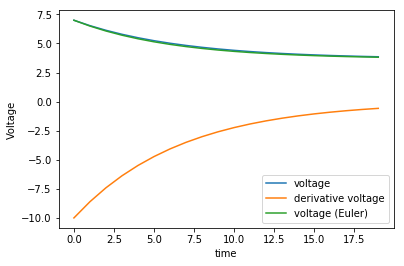

In [37]:
# initialize
gL = 1
gs = 2
EL = 3
Es = 4
A = 10

start = 0
iterations = 20
dt = 0.05
time = np.arange(start, iterations) * dt

# compute initial value voltage
initial_value = ((A + (gL * EL + gs * Es)) / (gL + gs))

# compute voltage
voltage_I = [compute_voltage_I(tp) for tp in time]    # offline
voltage_euler_I = euler_method_I(initial_value)       # online

# compute voltage derivative
voltage_der_I = [compute_voltage_der_I(V) for V in voltage_I]

# plot results
plot_I()

In [483]:
# phase_portrait_I()

# 2. Inhomogeneous differential equation I

### Compute voltage

In [480]:
def functionI(input):
    output = np.exp((-gL - gs) * (input)) * dt
    return output

def functionII():        
    output = np.zeros(iterations - 1)      
    for t in range(iterations - 1):
        output[t] = D * c[t] + gL * EL + gs * Es
    return output

def compute_voltage_II():
    
    # convolution
    g = [functionI(tp) for tp in time]
    f = functionII()
    V = np.convolve(g, f)
    
    val = [C * np.exp((-gs - gL) * tp) for tp in time]
    V = V[0:iterations] #+ val

    return V

In [449]:
def run_voltage_II():
    
    voltage = 0
    
    for t in range(iterations):
        voltage = compute_voltage_II()
        
    return voltage

### Compute voltage using Euler method

In [461]:
def compute_voltage_der_II(V, c):
    dV = (- gL - gs) * V + gs * Es + gL * EL + D * c
    return dV

In [458]:
def euler_method_II(initial_value):

    voltage_euler = np.ones(iterations) * initial_value
    
    for t in range(1, iterations):
        dVdt = compute_voltage_der_II(voltage_euler[t - 1], c[t - 1])
        voltage_euler[t] = voltage_euler[t - 1] + dt * dVdt
        
    return voltage_euler

### Plot results

In [486]:
def plot_II():
    pl.plot(voltage_II[0:iterations], label='voltage')
    pl.plot(voltage_euler_II, label='voltage (Euler)')
    # pl.plot(voltage_der_II, label='derivative voltage')
    pl.legend()

### Run simulation

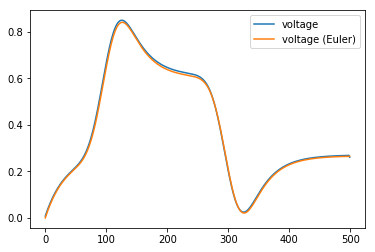

In [490]:
# initialize parameters
gL = 2
gs = 1
EL = 0.3
Es = 0.2
D = 1
C = 1

# initialize time component
start = 0
iterations = 500
dt = 0.01
time = np.arange(start, iterations) * dt

x, c = TVS_single()

# compute initial value voltage
# initial_value = (gL * EL + gs * Es + D * c[0]) / (gL + gs)
initial_value = 0

# compute voltage
voltage_II = run_voltage_II()
voltage_euler_II = euler_method_II(initial_value)

# compute voltage derivative
voltage_der_II = [compute_voltage_der_II(V, c) for V in voltage_II]

# plot results
plot_II()

### Phase portrait

In [115]:
def phase_portrait_II():
    y1 = np.linspace(start, iterations, 10)
    y2 = np.linspace(start, iterations, 10)

    Y1, Y2 = np.meshgrid(y1, y2)

    t = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    for i in range(NI):
        for j in range(NJ):
            x = Y1[i, j]
            y = Y2[i, j]
            u[i,j] = y1[i]
            v[i,j] = compute_voltage_der_II(y2[i], c[i])


    pl.quiver(Y1, Y2, u, v, color='k')
    pl.xlabel('time')
    pl.ylabel('voltage')

In [131]:
#phase_portrait_II()

# 3. Inhomogeneous differential equation II

# 4. Derive voltage

### Compute voltage

In [144]:
def compute_voltage_IV(D, x, xest):
    V = D * (x - xest) / D * (x + xest)
    return V

In [145]:
def run_voltage_IV():
    
    voltage = np.ones(iterations)
    
    for t in range(iterations):
        voltage[t] = compute_voltage_IV(D, x[t], x_est[t])
        
    return voltage

### Compute voltage using Euler method

In [146]:
def der_x_xest(x, x_est):
    
    dxdt = np.diff(x)/dt
    dxestdt = np.diff(x_est)/dt
    
    return dxdt, dxestdt

In [223]:
def compute_voltage_der_IV(x, xest, dxdt, dxestdt):
    
    g = (x + xest) * (x + xest) 
    dV = 2 * (   dxdt * (xest/g) - dxestdt * (x/g)   )
    return dV

In [227]:
def euler_method_IV(initial_value):

    voltage_euler = np.ones(iterations) * initial_value
    
    for t in range(1, iterations):
        dVdt = compute_voltage_der_IV(x[t - 1], x_est[t - 1], dxdt[t - 1], dxestdt[t - 1])
        voltage_euler[t] = voltage_euler[t - 1] + dt * dVdt
        
    return voltage_euler

### Plot results

In [229]:
def plot_IV():
    
    pl.plot(voltage_IV, label='voltage')
    pl.plot(voltage_euler_IV, label='voltage (Euler)')
    pl.legend()

### Run simulation

C:\Users\amber\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


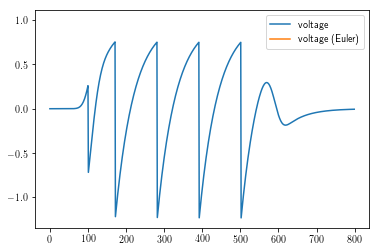

In [230]:
# initialize parameters
D = 1
x, x_est, iterations = conductance_sim()
dxdt, dxestdt = der_x_xest(x, x_est)

# compute initial value voltage
initial_value = 1

# compute voltage
voltage_IV = run_voltage_IV()
voltage_euler_IV = euler_method_IV(initial_value)

# plot results
plot_IV()

# print(voltage[0])
# print(voltage_euler[0])

### Phase portrait

# Voltage dynamics (exercises Dynamical Systems in Neuroscience)

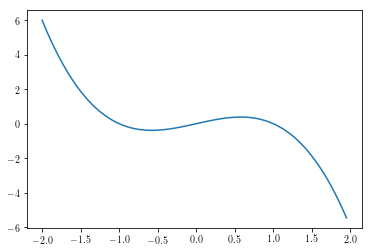

In [270]:
voltage = np.arange(-2, 2, 0.05)

def derivative(V):
    V = V - V**3
    return V

dV = [derivative(V) for V in voltage]

pl.plot(voltage, dV)

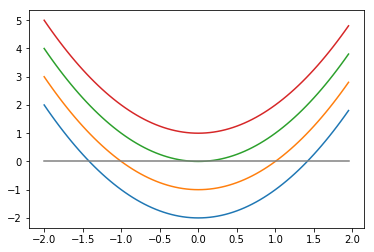

In [498]:
def derivative(I, V):
    V = I + V**2
    return V

I = np.arange(-2, 2)
voltage = np.arange(-2, 2, 0.05)

for i in range(len(I)):
    dV = [derivative(I[i], V) for V in voltage]
    pl.plot(voltage, dV)
    
pl.plot(voltage, np.zeros(len(voltage)), 'gray')

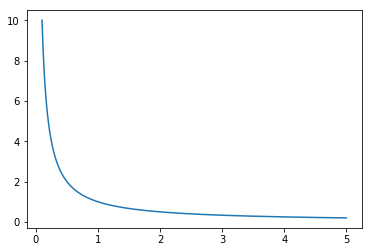

In [497]:
x = np.linspace(0.1, 5, 1000)

y = [1/(t) for t in x]

pl.plot(x, y)

In [ ]:
#         # initialize D
#         D = np.zeros((N, d))
        
#         if N == 3:
            
#             D[0][0] = 0
#             D[0][1] = 1
#             D[0][2] = 0.5

#             D[1][0] = 0.86
#             D[1][1] = -0.5
#             D[1][2] = -0.5

#             D[2][0] = -0.86
#             D[2][1] = -0.5
#             D[2][2] = -0.5
        
#         elif N == 4:
            
#             D[0][0] = 0
#             D[0][1] = 1
#             D[0][2] = -0.6

#             D[1][0] = 0.86
#             D[1][1] = -0.5
#             D[1][2] = -0.5

#             D[2][0] = -0.86
#             D[2][1] = -0.5
#             D[2][2] = -0.5

#             D[3][0] = 0
#             D[3][1] = 0
#             D[3][2] = 1
            
        
#         elif N == 5:
            
#             D[0][0] = 0
#             D[0][1] = 1
#             D[0][2] = 0

#             D[1][0] = 0.86
#             D[1][1] = -0.5
#             D[1][2] = 0

#             D[2][0] = -0.86
#             D[2][1] = -0.5
#             D[2][2] = 0

#             D[3][0] = 0
#             D[3][1] = 0
#             D[3][2] = 1

#             D[4][0] = 0
#             D[4][1] = 0
#             D[4][2] = -1
            
#         elif N == 6:
            
#             D[0][0] = 1
#             D[0][1] = 0
#             D[0][2] = 0

#             D[1][0] = -1
#             D[1][1] = 0
#             D[1][2] = 0

#             D[2][0] = 0
#             D[2][1] = 1
#             D[2][2] = 0
            
#             D[3][0] = 0
#             D[3][1] = -1
#             D[3][2] = 0

#             D[4][0] = 0
#             D[4][1] = 0
#             D[4][2] = 1

#             D[5][0] = 0
#             D[5][1] = 0
#             D[5][2] = -1
            
# #         elif N == 7:
            
# #             D[0][0] = 1
# #             D[0][1] = 0.2
# #             D[0][2] = 0.8

# #             D[1][0] = 1
# #             D[1][1] = 0.2
# #             D[1][2] = -0.8

# #             D[2][0] = 0
# #             D[2][1] = 1
# #             D[2][2] = 1
            
# #             D[3][0] = 0
# #             D[3][1] = 1
# #             D[3][2] = -1

# #             D[4][0] = -1
# #             D[4][1] = 0
# #             D[4][2] = 0.8

# #             D[5][0] = -1
# #             D[5][1] = 0
# #             D[5][2] = -1
            
# #             D[6][0] = 0
# #             D[6][1] = -1
# #             D[6][2] = 0.8

            
#         elif N == 8:
            
#             D[0][0] = 1
#             D[0][1] = 0.2
#             D[0][2] = 0.8

#             D[1][0] = 1
#             D[1][1] = 0.2
#             D[1][2] = -0.8

#             D[2][0] = 0
#             D[2][1] = 1
#             D[2][2] = 1
            
#             D[3][0] = 0
#             D[3][1] = 1
#             D[3][2] = -1

#             D[4][0] = -1
#             D[4][1] = 0
#             D[4][2] = 0.8

#             D[5][0] = -1
#             D[5][1] = 0
#             D[5][2] = -1
            
#             D[6][0] = 0
#             D[6][1] = -1
#             D[6][2] = 0.8
            
#             D[7][0] = 0
#             D[7][1] = -1
#             D[7][2] = -0.8
            